In [1]:
import os

import PIL.Image
from snowflake.snowpark import Session

try:
    from dotenv import load_dotenv
except ImportError:
    def load_dotenv(**kwargs):
        pass

load_dotenv(override=True)

connection_params = {
    "account": os.environ.get("SNOWFLAKE_ACCOUNT"),
    "user": os.environ.get("SNOWFLAKE_USER"),
    "password": os.environ.get("SNOWFLAKE_PASSWORD"),
    "role": "SYSADMIN",
}

session = Session.builder.configs(connection_params).create()

Create the objects for this demonstration.

In [2]:
session.sql("CREATE DATABASE IF NOT EXISTS PICTURE_DB;").collect()
session.sql("DROP SCHEMA IF EXISTS PICTURE_DB.PUBLIC;").collect()
session.sql("CREATE SCHEMA IF NOT EXISTS PICTURE_DB.COMMON;").collect()
session.sql("CREATE STAGE IF NOT EXISTS PICTURE_DB.COMMON.PICTURES;").collect()

session.sql(
    """
CREATE WAREHOUSE IF NOT EXISTS PICTURE_WH 
    WITH WAREHOUSE_SIZE = 'XSMALL' 
    WAREHOUSE_TYPE = 'STANDARD' 
    AUTO_SUSPEND = 60 
    AUTO_RESUME = TRUE 
    INITIALLY_SUSPENDED = TRUE;
"""
).collect()

[Row(status='PICTURE_WH already exists, statement succeeded.')]

Adjust our context.

In [3]:
session.use_database("PICTURE_DB")
session.use_schema("COMMON")
session.use_warehouse("PICTURE_WH")

Load the stage.

In [4]:
session.file.put("file://pictures/*.png", "@PICTURES")

[PutResult(source='carbon.png', target='carbon.png.gz', source_size=46105, target_size=0, source_compression='NONE', target_compression='GZIP', status='SKIPPED', message=''),
 PutResult(source='flowchart.png', target='flowchart.png.gz', source_size=158984, target_size=0, source_compression='NONE', target_compression='GZIP', status='SKIPPED', message='')]

List the contents of the stage.

In [5]:
session.sql("LS @PICTURES").show()

---------------------------------------------------------------------------------------------------------
|"name"                     |"size"  |"md5"                             |"last_modified"                |
---------------------------------------------------------------------------------------------------------
|pictures/carbon.png.gz     |45872   |dba021948121b5064f7ba6292c76ceee  |Fri, 28 Apr 2023 21:41:57 GMT  |
|pictures/flowchart.png.gz  |156528  |bd78801bdc7e793cdab803bcc934691c  |Fri, 28 Apr 2023 21:41:57 GMT  |
---------------------------------------------------------------------------------------------------------



Stream and view the image.

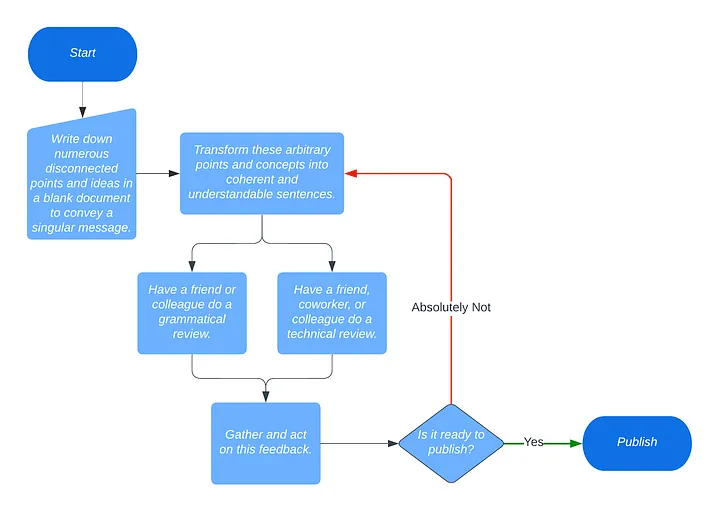

In [6]:
bytes_object = session.file.get_stream(
    "@pictures/flowchart.png.gz", decompress=True)
PIL.Image.open(bytes_object)